In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit
from numpy import exp
from numpy import sin
from numpy import tanh
from scipy.optimize import minimize
from scipy.optimize import dual_annealing
from scipy.optimize import differential_evolution

In [33]:
def get_lock_depth_from_params(params):
    a1,a2,b1,b2 = params
    lock_in_depth = [(b1-2)/a1,(b1+2)/a1,(b2-2)/a2,(b2+2)/a2]
    return lock_in_depth

In [34]:
def get_params_from_depths(lock_in_depth):
    l0,l1,l2,l3 = lock_in_depth
    params = [4/(l1-l0),4/(l3-l2),2*(l1+l0)/(l1-l0),2*(l3+l2)/(l3-l2)]
    return params

In [60]:
def e(z):
    idx = np.where(np.isclose(depth, z))[0]
    idx = idx[0]

    return 1 - fraction_data[idx]

In [36]:
def H(z):
    # Ensure z is treated properly, even if it's an array
    return -np.tanh(((c2 + c1) * (z - (c2 + c1) / 2)) / (c2 - c1))

In [37]:
def l (z,s,a1,b1,a2,b2):
    return e(z)/(1+exp(-a1*s+b1)) + (1-e(z))/(1+exp(-a2*s+b2))

In [38]:
def l_diff(z, s, a1, b1, a2, b2):
    term1 = (a1 * np.exp(-a1 * s + b1)) / (1 + np.exp(-a1 * s + b1))**2
    term2 = (a2 * np.exp(-a2 * s + b2)) / (1 + np.exp(-a2 * s + b2))**2
    return e(z) * term1 + (1 - e(z)) * term2

In [39]:
def integral(s, z, a1, a2, b1, b2):
    # Convert z to float to ensure scalar use in quad
    return H(float(z) - s) * l_diff(float(z), s, a1, b1, a2, b2)

In [40]:
def functional_integration(z, a1, a2, b1, b2):
    # Use quad with scalar z, converting array inputs to floats
    result, _ = quad(lambda s: integral(s, float(z), a1, a2, b1, b2), 0, float(z))
    return result

In [41]:
def get_magnetisation(z, params):
    a1, a2, b1, b2 = params
    
    # Vectorize the integration function to handle array inputs
    vec_func_integration = np.vectorize(functional_integration)
    M = vec_func_integration(z, a1, a2, b1, b2)
    
    return np.tanh(M * 10**3)

In [42]:
def huber_loss(params, z_data, M_obs, delta=1.0):
    # Compute predicted magnetization
    M_pred = get_magnetisation(z_data, params)
    
    # Compute the residuals
    residuals = M_obs - M_pred
    
    # Compute Huber loss
    loss = np.where(np.abs(residuals) <= delta,
                    0.5 * residuals ** 2,
                    delta * (np.abs(residuals) - 0.5 * delta))
    
    return np.mean(loss)

In [43]:
def random_restarts_optimization(loss_function, z_data, M_obs, bounds, n_restarts=10):
    solutions = []
    for i in range(n_restarts):
        # Generate a random initial guess within the bounds
        random_initial = [np.random.uniform(low, high) for low, high in bounds]
        
        # Minimize the loss function
        result = minimize(loss_function, random_initial, args=(z_data, M_obs), method='L-BFGS-B', bounds=bounds)
        solutions.append(result.x)
        
        print(f"Iteration: {i+1}")
    
    return solutions

In [44]:
c1 = 73
c2 = 74.5

In [47]:
_ , fraction_data = np.loadtxt('ez.txt', unpack = True)

In [48]:
polarity = np.loadtxt('Kuldara_polarity for Dima.txt')

In [49]:
polarity = np.loadtxt('Kuldara_polarity for Dima.txt')
M_obs = polarity[np.logical_not(np.logical_and(polarity[:,1]>-45,polarity[:,1]<45))]

In [50]:
depth, M_obs = M_obs[:,0],M_obs[:,1]

In [51]:
M_obs[M_obs > 0] = 1.
M_obs[M_obs < 0] = -1.

In [52]:
M_obs = np.array(M_obs)
depth = np.array(depth)

In [54]:
bounds = [(3., 7.),  # a1
          (0.5, 3.),  # a2
          (2.5, 4.8),    # b1
          (3., 5.)]    # b2

In [55]:
initial_params = [1.0, 1.0, 1.0, 1.0]

In [61]:
solutions = random_restarts_optimization(huber_loss, depth, M_obs, bounds, n_restarts=10)
print("Multiple solutions found:", solutions)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Multiple solutions found: [array([3.67972964, 2.97830614, 3.16650836, 4.58722444]), array([3.84404499, 2.74750601, 2.538911  , 3.85968027]), array([3.32238627, 0.7496949 , 3.1411026 , 4.53416455]), array([3.34558972, 1.48015208, 3.48336168, 4.0618509 ]), array([6.47327498, 2.76965298, 4.35468518, 3.09065425]), array([6.69889577, 2.92410126, 3.4371414 , 3.39993513]), array([6.69140491, 1.94871442, 3.77572073, 4.23874262]), array([5.56988949, 2.62978195, 4.1556325 , 3.94934256]), array([5.55802589, 2.35007984, 4.68976441, 3.9735564 ]), array([4.24612707, 0.85980309, 4.6015758 , 4.92664346])]


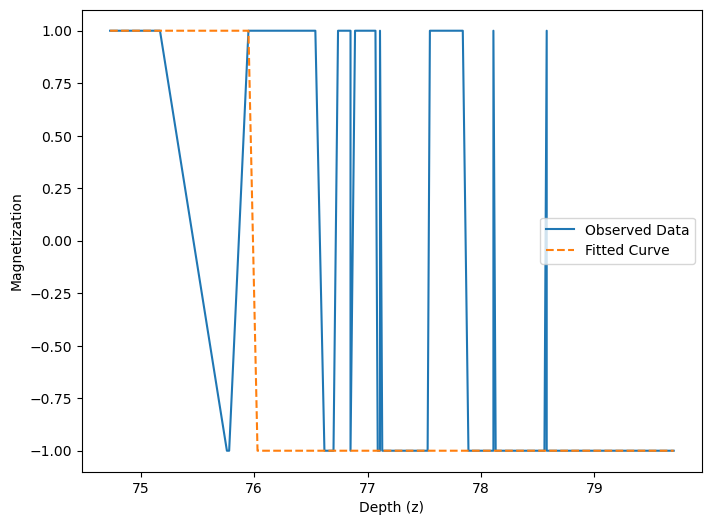

Depths: [0.612693817457561, 1.554728743979031, 3.403853140365842, 8.056081106948115]


In [71]:
ind = 9

M_optimized = get_magnetisation(depth, solutions[ind])

plt.figure(figsize=(8, 6))
plt.plot(depth, M_obs, label='Observed Data')  # Plot the observed data
plt.plot(depth, M_optimized, label='Fitted Curve',linestyle = 'dashed')  # Plot the fitted curve
plt.xlabel('Depth (z)')
plt.ylabel('Magnetization')
plt.legend()
plt.show()

print(f'Depths: {get_lock_depth_from_params(solutions[ind])}')